In [1]:
import os
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [2]:
csv_path = './datasets/birds/birds.csv'
base_path = './datasets/birds/'

df = pd.read_csv(csv_path, index_col=0)

id2label = pickle.load(open('checkpoints/vit_model/id2label.pkl', 'rb'))
num_classes = len(set(df['labels'].tolist()))
df.head()

,filepaths,labels,data set
0,train\AFRICAN CROWNED CRANE\001.jpg,AFRICAN CROWNED CRANE,train
1,train\AFRICAN CROWNED CRANE\002.jpg,AFRICAN CROWNED CRANE,train
2,train\AFRICAN CROWNED CRANE\003.jpg,AFRICAN CROWNED CRANE,train
3,train\AFRICAN CROWNED CRANE\004.jpg,AFRICAN CROWNED CRANE,train
4,train\AFRICAN CROWNED CRANE\005.jpg,AFRICAN CROWNED CRANE,train


In [3]:
img_size = 224

def create_model():
    vit_model = vit.vit_b16(
        image_size=img_size,
        pretrained=True,
        include_top=False,
        pretrained_top=False,
    )

    finetune_at = 28
    for layer in vit_model.layers[:finetune_at - 1]:
        layer.trainable = False

    model = tf.keras.Sequential([
            vit_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, 'softmax')
        ],
        name = 'vision_transformer')
    return model

model = create_model()
model.load_weights('./checkpoints/vit_model')

C:\Users\mahoto\Anaconda3\envs\tensorflow\lib\site-packages\vit_keras\utils.py:77: UserWarning: Resizing position embeddings from 24 to 14
  warnings.warn(


In [4]:
import random
from PIL import Image

train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'test'].sample(frac=1)

def load_image(image_path):
    image = Image.open(base_path+image_path.replace('\\', '/'))
    im = image.resize((img_size, img_size))
    im = np.array(im)
    im = im / 255
    im = np.expand_dims(im, 0)
    return im

def top_k_predictions(im, k=3):
    predict = model(im)
    top_probs, top_idxs = tf.math.top_k(input=predict, k=k)
    top_probs = top_probs[0].numpy().tolist()
    top_idxs = top_idxs.numpy().tolist()[0]
    top_labels = [id2label[i] for i in top_idxs]
    for l, p in zip(top_labels, top_probs):
        print(f'{l}: {p}')
    return top_labels, top_idxs, top_probs

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    delta = image - baseline_x
    images = baseline_x +  alphas_x * delta
    return images


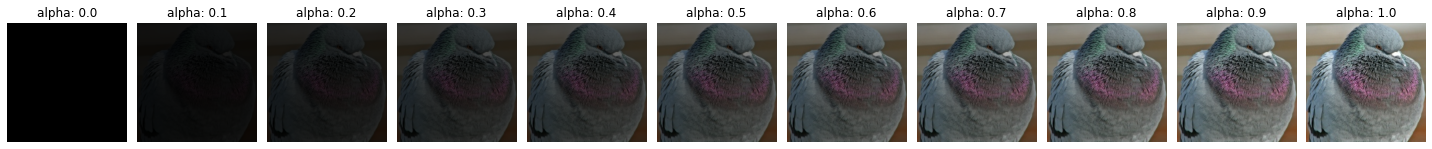

In [5]:
m_steps = 200
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
baseline = tf.zeros(shape=(img_size, img_size, 3))

image_path = valid_df['filepaths'].tolist()[0]
im = load_image(image_path)
interpolated_images = interpolate_images(
    baseline=baseline,
    image=im.astype('float32'),
    alphas=alphas)

fig = plt.figure(figsize=(20, 20))
i, step_size = 0, int(m_steps / 10)
for alpha, image in zip(alphas[0::step_size], interpolated_images[0::step_size]):
  i += 1
  plt.subplot(1, len(alphas[0::step_size]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()

In [6]:
def compute_gradients(images, target_class_idx, batch_size=2):
    ps = []
    for i in range(int(images.shape[0] / batch_size+1)):
        batch_image = images[i*batch_size: (i+1)*batch_size]
        with tf.GradientTape() as tape:
            tape.watch(batch_image)
            probs = model(batch_image)
            probs = probs[:, target_class_idx]
        gradient_path = tape.gradient(probs, batch_image)
        ps.append(gradient_path)
    if len(ps) > 2:
        gradients_path = tf.concat(ps, 0)
    else:
        gradients_path = ps[0]
    return gradients_path

_, idxs, _ = top_k_predictions(im, k=1)
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=idxs[0]
)
print(path_gradients.shape)

ROCK DOVE: 0.9993433356285095
(201, 224, 224, 3)


(201, 224, 224, 3)


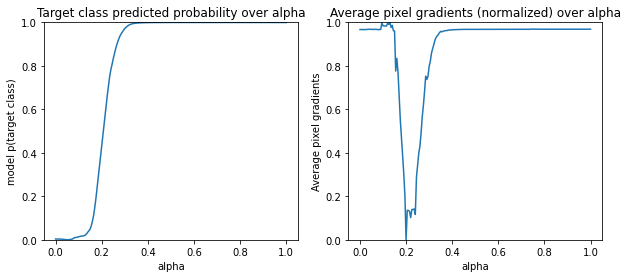

In [7]:
pred_proba = model(interpolated_images)
pred_proba = pred_proba[:, idxs[0]]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
print(path_gradients.shape)
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [8]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

(224, 224, 3)


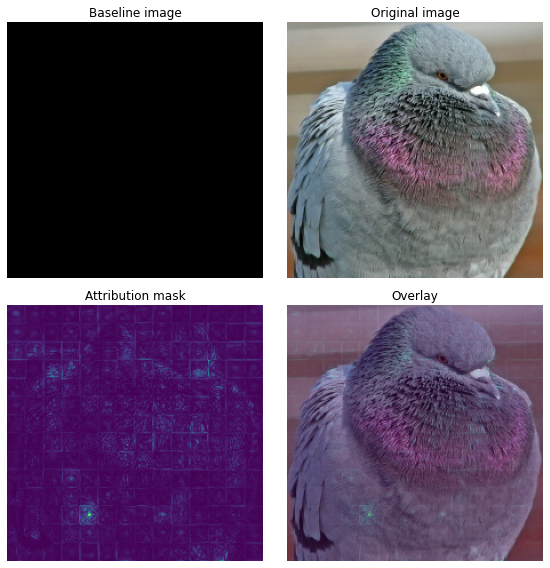

In [9]:
cmap, overlay_alpha = None, 0.6

integrated_gradients = (image - baseline) * ig
attribution_mask = tf.reduce_sum(tf.math.abs(integrated_gradients), axis=-1)
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

axs[0, 0].set_title('Baseline image')
axs[0, 0].imshow(baseline)
axs[0, 0].axis('off')

axs[0, 1].set_title('Original image')
axs[0, 1].imshow(image)
axs[0, 1].axis('off')

axs[1, 0].set_title('Attribution mask')
axs[1, 0].imshow(attribution_mask, cmap=cmap)
axs[1, 0].axis('off')

axs[1, 1].set_title('Overlay')
axs[1, 1].imshow(attribution_mask, cmap=cmap)
axs[1, 1].imshow(image, alpha=overlay_alpha)
axs[1, 1].axis('off')

plt.tight_layout()